# import packages

In [44]:

# data handling
import pandas as pd
import numpy as np
from datetime import timedelta

#EDA
import matplotlib.pyplot as plt
import seaborn as sns

#chi-square test
import scipy.stats as stats

# Machine learning model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#load data and clean/pre-process

In [3]:
#Load data
users = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/takehome_users.csv', encoding='latin-1')
engagement = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/takehome_user_engagement.csv')

In [6]:

# Clean and preprocess data
# Convert timestamp columns to datetime
users['creation_time'] = pd.to_datetime(users['creation_time'])
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])


In [7]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [8]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


#define adopted users

In [11]:
# Define a function to identify adopted users
def find_adopted_users(user_data):
    if len(user_data) < 3:
        return 0

    user_data = user_data.sort_values(by='time_stamp')
    user_data['time_diff'] = user_data['time_stamp'].diff()
    user_data['rolling_sum'] = user_data['time_diff'].dt.total_seconds().rolling(window=3, min_periods=1).sum()

    if any(user_data['rolling_sum'] <= 7 * 24 * 60 * 60):  # 7 days in seconds
        return 1
    else:
        return 0

# Apply the function to each user and create a new column 'adopted'
adopted_users = engagement.groupby('user_id').apply(find_adopted_users)
users['adopted'] = users['object_id'].isin(adopted_users.index).astype(int)



In [16]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,1


#exploratory data analysis

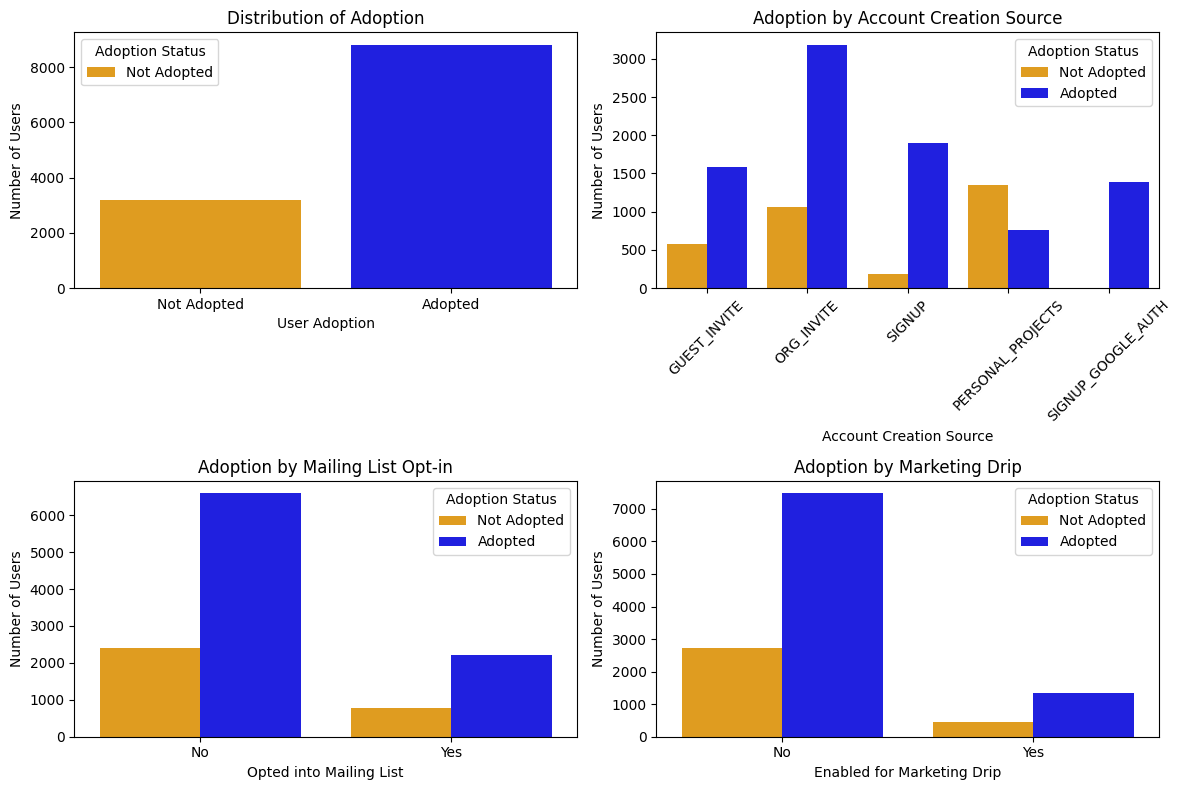

In [45]:
#EDA

# Create a 2x2 subplot layout
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plot 1: Distribution of Adoption
sns.countplot(x='adopted', data=users, palette=['orange', 'blue'], ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Adoption')
axes[0, 0].set_xlabel('User Adoption')
axes[0, 0].set_ylabel('Number of Users')
axes[0, 0].set_xticks(ticks=[0, 1])
axes[0, 0].set_xticklabels(['Not Adopted', 'Adopted'])
axes[0, 0].legend(title='Adoption Status', labels=['Not Adopted', 'Adopted'])

# Plot 2: Adoption by Account Creation Source
sns.countplot(x='creation_source', hue='adopted', data=users, palette=['orange', 'blue'], ax=axes[0, 1])
axes[0, 1].set_title('Adoption by Account Creation Source')
axes[0, 1].set_xlabel('Account Creation Source')
axes[0, 1].set_ylabel('Number of Users')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)
axes[0, 1].legend(title='Adoption Status', labels=['Not Adopted', 'Adopted'])

# Plot 3: Adoption by Mailing List Opt-in
sns.countplot(x='opted_in_to_mailing_list', hue='adopted', data=users, palette=['orange', 'blue'], ax=axes[1, 0])
axes[1, 0].set_title('Adoption by Mailing List Opt-in')
axes[1, 0].set_xlabel('Opted into Mailing List')
axes[1, 0].set_ylabel('Number of Users')
axes[1, 0].set_xticks(ticks=[0, 1])
axes[1, 0].set_xticklabels(['No', 'Yes'])
axes[1, 0].legend(title='Adoption Status', labels=['Not Adopted', 'Adopted'])

# Plot 4: Adoption by Marketing Drip
sns.countplot(x='enabled_for_marketing_drip', hue='adopted', data=users, palette=['orange', 'blue'], ax=axes[1, 1])
axes[1, 1].set_title('Adoption by Marketing Drip')
axes[1, 1].set_xlabel('Enabled for Marketing Drip')
axes[1, 1].set_ylabel('Number of Users')
axes[1, 1].set_xticks(ticks=[0, 1])
axes[1, 1].set_xticklabels(['No', 'Yes'])
axes[1, 1].legend(title='Adoption Status', labels=['Not Adopted', 'Adopted'])

# Adjust layout spacing
plt.tight_layout()

# Show the subplot layout
plt.show()


conclusion: by looking at plots "account creation source" contribute to user adoption more than other variables such mailing list and marketing drip


To determine which variable is more contributing for adoption among 'creation_source', 'opted_in_to_mailing_list', and 'enabled_for_marketing_drip',
we can perform a statistical analysis or use machine learning techniques to evaluate the feature importance. Let's go through both approaches:

#1. Statistical Analysis:

In [34]:

#One simple way to assess the contribution of each variable is to use a chi-squared test for independence.
#This test can help you understand if there is a significant association between the categorical variables and user adoption.

#If the p-value is below a certain significance level (e.g., 0.05),
#you can conclude that there is a significant association between the variables.
#However, this test doesn't quantify the strength of the association.

# Create a contingency table
contingency_table = pd.crosstab(users['creation_source'], users['adopted'])
# Perform the chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print("Chi-Squared Value:", chi2)
print("P-value:", p)

# Create a contingency table
contingency_table = pd.crosstab(users['opted_in_to_mailing_list'], users['adopted'])
# Perform the chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print("Chi-Squared Value:", chi2)
print("P-value:", p)

# Create a contingency table
contingency_table = pd.crosstab(users['enabled_for_marketing_drip'], users['adopted'])
# Perform the chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print("Chi-Squared Value:", chi2)
print("P-value:", p)


Chi-Squared Value: 2339.949831442068
P-value: 0.0
Chi-Squared Value: 1.3346712054178995
P-value: 0.24797590257761692
Chi-Squared Value: 1.772211064163665
P-value: 0.18310867899393116


conclusion: by looking at plots "account creation source" contribute to user adoption more than other variables such mailing list and marketing drip. siliar observation came from plots as well.

#2. Machine Learning for Feature Importance and classify user adoption :

In [49]:
# Select features and target
features = ['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip']
X = pd.get_dummies(users[features], columns=['creation_source'], drop_first=True)
y = users['adopted']

X.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,0,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [50]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: adopted, dtype: int64

In [39]:

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Produce a report with findings
# You can interpret feature importances from the trained model to understand variable influence
importances = model.feature_importances_
feature_names = X.columns

for feature, importance in zip(feature_names, importances):
    print(f'{feature}: {importance}')


              precision    recall  f1-score   support

           0       0.62      0.43      0.51       620
           1       0.82      0.91      0.86      1780

    accuracy                           0.79      2400
   macro avg       0.72      0.67      0.68      2400
weighted avg       0.77      0.79      0.77      2400

opted_in_to_mailing_list: 0.003302324786863296
enabled_for_marketing_drip: 0.004313466019424092
creation_source_ORG_INVITE: 0.029611942625643692
creation_source_PERSONAL_PROJECTS: 0.6414060589482454
creation_source_SIGNUP: 0.12777937237095296
creation_source_SIGNUP_GOOGLE_AUTH: 0.1935868352488706


Conclusion: by looking at feature importance values "account creation source" contribute to user adoption similar observation came from plot and chi squared test.

In [54]:
X_test

,opted_in_to_mailing_list,enabled_for_marketing_drip,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
1935,0,0,1,0,0,0
6494,0,1,1,0,0,0
1720,1,0,1,0,0,0
9120,0,0,0,0,0,0
360,1,1,0,1,0,0
...,...,...,...,...,...,...
1195,1,1,0,0,0,0
11877,1,0,0,1,0,0
5421,0,0,0,1,0,0
3855,0,0,1,0,0,0


for giving any test set with feature like shown above [opted_in_to_mailing_list , enabled_for_marketing_drip, 	creation_source_ORG_INVITE,	creation_source_PERSONAL_PROJECTS, 	creation_source_SIGNUP, creation_source_SIGNUP_GOOGLE_AUTH] can be used for classfiying user adoption